<a href="https://colab.research.google.com/github/Anarv2104/Image-Generation-Model/blob/main/final_image_code_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision pycocotools
!pip install nltk

In [1]:
# Create a directory for the dataset
!mkdir coco_data

# Download images and annotations
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_data/train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_data/annotations.zip

# Unzip the files
!unzip coco_data/train2017.zip -d coco_data/
!unzip coco_data/annotations.zip -d coco_data/

Streaming output truncated to the last 5000 lines.
 extracting: coco_data/train2017/000000563584.jpg  
 extracting: coco_data/train2017/000000276069.jpg  
 extracting: coco_data/train2017/000000401194.jpg  
 extracting: coco_data/train2017/000000502089.jpg  
 extracting: coco_data/train2017/000000192183.jpg  
 extracting: coco_data/train2017/000000425127.jpg  
 extracting: coco_data/train2017/000000126766.jpg  
 extracting: coco_data/train2017/000000324161.jpg  
 extracting: coco_data/train2017/000000452746.jpg  
 extracting: coco_data/train2017/000000423782.jpg  
 extracting: coco_data/train2017/000000546343.jpg  
 extracting: coco_data/train2017/000000249290.jpg  
 extracting: coco_data/train2017/000000025529.jpg  
 extracting: coco_data/train2017/000000316928.jpg  
 extracting: coco_data/train2017/000000337866.jpg  
 extracting: coco_data/train2017/000000547768.jpg  
 extracting: coco_data/train2017/000000423162.jpg  
 extracting: coco_data/train2017/000000224149.jpg  
 extracting: 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from pycocotools.coco import COCO
from PIL import Image
import nltk
from nltk.tokenize import word_tokenize
import os
import matplotlib.pyplot as plt

# Download NLTK tokenizer data
nltk.download('punkt')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using device: cuda


In [3]:
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transform=None, max_length=20):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.anns.keys())
        self.transform = transform
        self.max_length = max_length

        self.word_to_idx = {'<pad>': 0, '<unk>': 1}
        self.idx_to_word = {0: '<pad>', 1: '<unk>'}
        self.build_vocabulary()

    def build_vocabulary(self):
        idx = 2
        for ann_id in self.ids:
            caption = self.coco.anns[ann_id]['caption']
            tokens = word_tokenize(caption.lower())
            for token in tokens:
                if token not in self.word_to_idx:
                    self.word_to_idx[token] = idx
                    self.idx_to_word[idx] = token
                    idx += 1

    def __getitem__(self, index):
        ann_id = self.ids[index]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform:
            image = self.transform(image)

        tokens = word_tokenize(caption.lower())
        encoded = [self.word_to_idx.get(token, self.word_to_idx['<unk>']) for token in tokens]
        if len(encoded) < self.max_length:
            encoded += [self.word_to_idx['<pad>']] * (self.max_length - len(encoded))
        else:
            encoded = encoded[:self.max_length]

        return image, torch.tensor(encoded)

    def __len__(self):
        return len(self.ids)

In [6]:
# Cell 3: Define the Generator and Discriminator Models
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 3 * 64 * 64),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 3, 64, 64)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 64 * 64, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

# Data Preparation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

root = '/content/coco_data/train2017'
annFile = '/content/coco_data/annotations/captions_train2017.json'

dataset = CocoDataset(root, annFile, transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model Hyperparameters
latent_dim = 100  # Size of the noise vector
vocab_size = len(dataset.word_to_idx)
text_embedding_dim = 256
hidden_dim = 256

# Initialize Models
text_encoder = TextEncoder(vocab_size, 300, hidden_dim).to(device)
generator = Generator(latent_dim, hidden_dim).to(device)
discriminator = Discriminator(hidden_dim).to(device)

# Optimizers and Loss Function
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Training Loop
for epoch in range(50):
    for i, (images, captions) in enumerate(dataloader):
        batch_size = images.size(0)

        # Move data to the appropriate device
        images = images.to(device)
        captions = captions.to(device)

        # Generate text embeddings
        text_embedding = text_encoder(captions).view(batch_size, -1)

        # =======================
        # Train the Discriminator
        # =======================
        d_optimizer.zero_grad()

        z = torch.randn(batch_size, latent_dim).to(device)
        with torch.no_grad():
            fake_images = generator(z, text_embedding)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        d_real_loss = criterion(discriminator(images, text_embedding), real_labels)
        d_fake_loss = criterion(discriminator(fake_images.detach(), text_embedding), fake_labels)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        # ===================
        # Train the Generator (Updated)
        # ===================
        g_optimizer.zero_grad()

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z, text_embedding)

        discriminator_output = discriminator(fake_images, text_embedding)

        g_loss = criterion(discriminator_output, real_labels)

        # Backpropagation without retain_graph=True
        g_loss.backward()
        g_optimizer.step()

        # Print progress every 100 steps
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/50], Step [{i+1}/{len(dataloader)}], "
                  f"D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

    # Save generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(25, latent_dim).to(device)
            sample_text_embedding = text_encoder(captions[:25]).view(25, -1).to(device)
            generated_images = generator(z, sample_text_embedding).cpu()
        save_image(generated_images, f"generated_images_epoch_{epoch+1}.png", nrow=5, normalize=True)

print("Training finished!")

# Function to Generate an Image from Text
def generate_image(text):
    # Tokenize and encode the input text
    tokens = word_tokenize(text.lower())
    encoded = [dataset.word_to_idx.get(t, dataset.word_to_idx['<unk>']) for t in tokens]
    caption = torch.tensor(encoded).unsqueeze(0).to(device)  # Add batch dimension

    # Generate latent noise vector
    z = torch.randn(1, latent_dim).to(device)

    # Generate image without tracking gradients
    with torch.no_grad():
        generated_image = generator(z, text_encoder(caption)).squeeze(0).cpu()

    return generated_image

# Example usage
generated = generate_image("A dog sitting in a field of flowers")

plt.imshow(generated.permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.axis('off')
plt.show()


In [7]:
# Cell 4: Initialize Models, Optimizers, and Dataset
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

root = "/content/coco_data/train2017"
annFile = "/content/coco_data/annotations/captions_train2017.json"
dataset = CocoDataset(root, annFile, transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


In [8]:
# Cell 5: Training Loop
for epoch in range(5):  # Use fewer epochs for testing
    for i, (images, _) in enumerate(dataloader):
        batch_size = images.size(0)

        # Move images to the device
        real_images = images.to(device)

        # Train Discriminator
        d_optimizer.zero_grad()

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_loss = criterion(discriminator(real_images), real_labels)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z).detach()
        fake_loss = criterion(discriminator(fake_images), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()

        z = torch.randn(batch_size, latent_dim).to(device)
        generated_images = generator(z)

        g_loss = criterion(discriminator(generated_images), real_labels)

        g_loss.backward()  # No retain_graph needed here
        g_optimizer.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/5], Step [{i+1}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # Save generated images every epoch
    with torch.no_grad():
        z = torch.randn(25, latent_dim).to(device)
        sample_images = generator(z).cpu()
        save_image(sample_images, f"generated_epoch_{epoch+1}.png", nrow=5, normalize=True)

print("Training finished!")

Epoch [1/5], Step [1/9247], D Loss: 1.3876, G Loss: 1.1669
Epoch [1/5], Step [11/9247], D Loss: 0.2094, G Loss: 2.7484
Epoch [1/5], Step [21/9247], D Loss: 0.4199, G Loss: 1.6439
Epoch [1/5], Step [31/9247], D Loss: 0.3504, G Loss: 2.1058
Epoch [1/5], Step [41/9247], D Loss: 0.4298, G Loss: 2.1246
Epoch [1/5], Step [51/9247], D Loss: 0.6303, G Loss: 2.0750
Epoch [1/5], Step [61/9247], D Loss: 0.5345, G Loss: 2.5375
Epoch [1/5], Step [71/9247], D Loss: 0.3910, G Loss: 3.2099
Epoch [1/5], Step [81/9247], D Loss: 0.1577, G Loss: 3.9651
Epoch [1/5], Step [91/9247], D Loss: 0.0750, G Loss: 4.7760
Epoch [1/5], Step [101/9247], D Loss: 0.1281, G Loss: 4.7560
Epoch [1/5], Step [111/9247], D Loss: 0.2022, G Loss: 5.3930
Epoch [1/5], Step [121/9247], D Loss: 0.0856, G Loss: 5.8302
Epoch [1/5], Step [131/9247], D Loss: 0.1685, G Loss: 5.8475
Epoch [1/5], Step [141/9247], D Loss: 0.2158, G Loss: 6.0664
Epoch [1/5], Step [151/9247], D Loss: 0.1711, G Loss: 6.8876
Epoch [1/5], Step [161/9247], D Los

KeyboardInterrupt: 

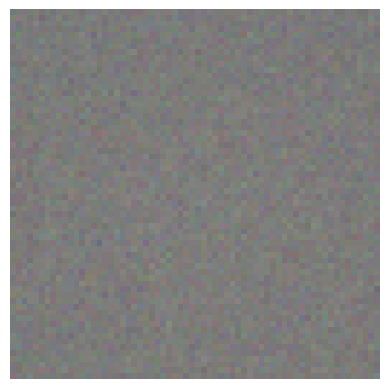

In [9]:
# Cell 6: Image Generation Function
def generate_image_from_noise():
    z = torch.randn(1, latent_dim).to(device)
    with torch.no_grad():
        generated_image = generator(z).cpu().squeeze(0)
    return generated_image

# Generate and Display Image
generated_image = generate_image_from_noise()
plt.imshow(generated_image.permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.axis('off')
plt.show()